## __XDF latency analysis of LSL data streams: Unity (triggered) vs EEG (measured)__

### __Situation__ 
#### Every 500ms a beep sound is played and the background color changes one frame from black to white.

#### __Unity (90 FPS):__
- Color change (black or white background)
- Beep sound (audio playing or not)

#### __EEG (1024 Hz):__
- Photodiode (light sensor)
- Microphone (audio sensor)


#### __TODO__
* [ ] Find out why sometimes Unity timestamps start before the EEG ones
* [ ] Find out why sometimes there are two Diode spikes during one colour change, check recording[14] (two diodes)
* [ ] Find out why first and last timestamps, and sample count on file info are different than the actual ones
* [ ] Plot grand average for timesamps distance and latencies
* [ ] Check peak detection, display missing white frames and played audios as dataframe

#### __Dependencies__

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyxdf
import seaborn as sns

from IPython.display import display
from multiprocessing import Pool, cpu_count
from scipy.signal import find_peaks
from tqdm.notebook import trange, tqdm

#### __Files (recordings)__

In [2]:
files = os.listdir("data")  # get all files from the folder "data"
files.sort()  # sort them alphabetically
recordings = {}

for file in files:
    # filter hidden/config files and folders
    if file.startswith(".") or os.path.isdir(f"data/{file}"):
        files.remove(file)  # remove hidden/config file

# short tests were excluded as they were too short and had strange statistics
print(f"Excluded: {os.listdir('data/short')}")

for i, file in enumerate(files):  # store and display all files
    recordings[i] = {"file": file}

files = [f.split(".")[0] for f in files]
print("Included:")
display(recordings)

Excluded: ['test.xdf', 'short_test_old1.xdf', 'short_new.xdf', 'short_test.xdf']
Included:


{0: {'file': 'final_test.xdf'},
 1: {'file': 'ftest1.xdf'},
 2: {'file': 'ftest2.xdf'},
 3: {'file': 'ftest3.xdf'},
 4: {'file': 'ftest_build1.xdf'},
 5: {'file': 'ftest_build2.xdf'},
 6: {'file': 'ftest_build3.xdf'},
 7: {'file': 'ftest_lsl12.xdf'},
 8: {'file': 'long2.xdf'},
 9: {'file': 'long3.xdf'},
 10: {'file': 'long4.xdf'}}

#### __Helper functions__

In [3]:
cores = cpu_count()
%matplotlib inline
# set pandas float display format
pd.options.display.float_format = "{:.5f}".format


def color_checks(val):
    if val == "✔":
        color = "green"
    elif val == "✗":
        color = "red"
    else:
        color = "blue"
    return "color: %s" % color


def correct_timestamps(ts):
    # calculate time values from 0
    corrected = [0]
    length = len(ts)
    [corrected.append(ts[i + 1] - ts[0]) for i in range(length) if i < length - 1]
    return np.array(corrected)


def select_streams(streams):
    # stream names
    a_ch_name = "Audio"
    c_ch_name = "Diode"
    e_ch_name = "openvibeSignal"

    # get all current streams with their positions on the recording
    # example: {'Diode': 0, 'Audio': 1, 'openvibeSignal': 2}
    s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}

    # store and return their positions
    a = s_channels[a_ch_name]  # unity audio stream channel
    c = s_channels[c_ch_name]  # unity color stream channel
    e = s_channels[e_ch_name]  # eeg stream channel (diode and microphone)
    return a, c, e

#### __Preprocess data. For each recording:__ 
1. Load XDF file (recording)
2. Store selected streams information
3. Store original timestamps
4. Compare streams first timestamp distance and order
5. Correct and store original timestamps
6. Store Unity values (audio playing and color changed)
7. Select and store EEG values (microphone and photodiode)

Result format:
```json
{
    'file': 'filename.xdf',
    'unity': {
        'info': {
            'name': '',
            'type': '',
            'nominal_srate': '',
            'effective_srate': '',
            'created_at': '',
            'hostname': '',
            'first_timestamp': '',
            'last_timestamp': '',
            'sample_count': ''
        },
        'time_stamps': array([]),
        'timestamps': array([]),
        'audio': array([]),
        'color': array([])
    },
    'eeg': {
        'info': {
            'name': '',
            'type': '',
            'nominal_srate': '',
            'effective_srate': '',
            'created_at': '',
            'hostname': '',
            'first_timestamp': '',
            'last_timestamp': '',
            'sample_count': ''
        },
        'time_stamps': array([]),
        'timestamps': array([]),
        'audio': array([], dtype=float32),
        'color': array([], dtype=float32)
    },
    'two_computers': boolean,  // recording with two computers
    'eeg_starts': boolean,  // eeg received before unity
    'lsl_aligned': boolean,  // lsl timestamps enforced on OpenVibe
    'unity_first': boolean,  // unity first timestamps same as file info
    'unity_last': boolean,  // unity last timestamps same as file info
    'length_unity_audio': boolean,  // length of unity timestamps and audio coincide
    'length_unity_color': boolean,  // length of unity timestamps and color coincide
    'eeg_first': boolean,  // eeg first timestamps same as file info
    'eeg_last': boolean,  // eeg last timestamps same as file info
    'length_eeg_audio': boolean,  // length of eeg timestamps and audio coincide
    'length_eeg_color': boolean  // length of eeg timestamps and color coincide
}
```

In [4]:
# check all files
m_format = "{desc}:{bar}{percentage:3.0f}% {n_fmt}/{total_fmt} in {elapsed_s:.2f}s"
s_format = (
    "{desc}:{bar}{percentage:3.0f}% {n_fmt}/{total_fmt}{postfix} in {elapsed_s:.2f}s"
)
main_bar = tqdm(
    recordings,
    desc="Processed",
    dynamic_ncols=True,
    mininterval=0.001,
    bar_format=m_format,
)
for k in main_bar:
    file = recordings[k]["file"]  # current filename
    pbar = tqdm(
        range(7),
        desc=f"recordings[{k:2.0f}]",
        mininterval=0.001,
        maxinterval=1,
        bar_format=s_format,
    )
    pbar.set_postfix(file=file)
    # add unity and eeg entries
    recordings[k]["unity"] = {}
    recordings[k]["eeg"] = {}

    # 1. Load the XDF file
    postfix = {"step": "1. Load the XDF file", "file": file}
    pbar.set_postfix(postfix)
    streams, fileheader = pyxdf.load_xdf(f"data/{file}")

    # select the data stream channels
    a_ch, c_ch, e_ch = select_streams(streams)
    pbar.update(1)

    # 2. Store selected stream info (only useful info)
    postfix = {"step": "2. Store selected stream info", "file": file}
    pbar.set_postfix(postfix)
    # keys to keep from streams[ch]["info"]
    i_keys = [
        "name",
        "type",
        "nominal_srate",
        "effective_srate",
        "created_at",
        "hostname",
    ]
    # keys to keep from streams[ch]["footer"]["info"]
    f_keys = ["first_timestamp", "last_timestamp", "sample_count"]
    # first add info dict for each stream
    recordings[k]["unity"] = {"info": {}}
    recordings[k]["eeg"] = {"info": {}}
    for key in i_keys:
        u_v = streams[a_ch]["info"][key]
        e_v = streams[e_ch]["info"][key]
        if type(u_v) == list and len(u_v) > 0:  # same for e_k, no need to check again
            # remove list format as 1-element lists
            u_v = u_v[0]
            e_v = e_v[0]
        recordings[k]["unity"]["info"][key] = u_v
        recordings[k]["eeg"]["info"][key] = e_v
    for key in f_keys:
        u_v = streams[a_ch]["footer"]["info"][key]
        e_v = streams[e_ch]["footer"]["info"][key]
        if type(u_v) == list and len(u_v) > 0:
            u_v = u_v[0]
            e_v = e_v[0]
        recordings[k]["unity"]["info"][key] = u_v
        recordings[k]["eeg"]["info"][key] = e_v

    # store if two computers were used (hostname comparison)
    u_host = recordings[k]["unity"]["info"]["hostname"]
    e_host = recordings[k]["eeg"]["info"]["hostname"]
    recordings[k]["two_computers"] = u_host == e_host
    pbar.update(1)

    # 3. Store timestamps
    postfix = {"step": "3. Store timestamps", "file": file}
    pbar.set_postfix(postfix)
    streams[a_ch]["time_stamps"] = np.array(streams[a_ch]["time_stamps"])
    streams[e_ch]["time_stamps"] = np.array(streams[e_ch]["time_stamps"])
    recordings[k]["unity"]["time_stamps"] = streams[a_ch]["time_stamps"]
    recordings[k]["eeg"]["time_stamps"] = streams[e_ch]["time_stamps"]
    pbar.update(1)

    # 4. Compare streams timestamps distance and order
    # store EEG received first (True/False)
    postfix = {"step": "4. Compare streams timestamps distance and order", "file": file}
    pbar.set_postfix(postfix)
    unity_first = streams[a_ch]["time_stamps"][0]
    eeg_first = streams[e_ch]["time_stamps"][0]
    time_diff = unity_first - eeg_first
    # if diff bigger than eeg sample distance (0.98ms), something went wrong
    # bool cast needed, otherwise type is numpy bool
    recordings[k]["eeg_starts"] = bool(time_diff >= -0.00098)
    # if diff bigger than 1 second, timestamps are not aligned -> wrong recording
    recordings[k]["lsl_aligned"] = bool(time_diff < 1)
    pbar.update(1)

    # 5. Correct and store timestamps
    postfix = {"step": "5. Correct and store timestamps", "file": file}
    pbar.set_postfix(postfix)
    u_corrected = correct_timestamps(streams[a_ch]["time_stamps"])
    e_corrected = correct_timestamps(streams[e_ch]["time_stamps"])
    # recorrect unity timestamps with eeg starting at 0
    # shift values according to the diff: left (negative) or right (positive)
    u_corrected = np.array([i + time_diff for i in u_corrected])
    # store corrected timestamps (timestamps -> corrected, time_stamps -> original)
    recordings[k]["unity"]["timestamps"] = u_corrected
    recordings[k]["eeg"]["timestamps"] = e_corrected
    pbar.update(1)

    # 6. Store Unity values (audio playing and color changed)
    postfix = {"step": "6. Store Unity values", "file": file}
    pbar.set_postfix(postfix)
    # format: [currentFrame, value, timestamp] -> we store value
    unity_a = np.transpose(streams[a_ch]["time_series"])[1]
    unity_c = np.transpose(streams[c_ch]["time_series"])[1]
    recordings[k]["unity"]["audio"] = unity_a.astype(int)
    recordings[k]["unity"]["color"] = unity_c.astype(int)
    pbar.update(1)

    # 7. Select and store EEG values (microphone and photodiode)
    postfix = {"step": "7. Select and store EEG values", "file": file}
    pbar.set_postfix(postfix)
    # select microphone and diode values
    eeg = np.transpose(streams[e_ch]["time_series"])

    # microphone data can be on channels 69 and 70, select the right one
    eeg_audio = eeg[68] if max(eeg[68]) != 0.0 else eeg[69]

    # diode data can be on channels 65 and 66, select the right one
    eeg_color = eeg[64] if max(eeg[64]) != 0.0 else eeg[65]
    eeg_color = -eeg_color  # invert diode data polarity, easier to visualize

    # store them
    recordings[k]["eeg"]["audio"] = eeg_audio
    recordings[k]["eeg"]["color"] = eeg_color
    # store if first and last timestamps coincide with file info
    # also if length of values and timestamps coincide
    for stream in ["unity", "eeg"]:
        # timestamps check
        o_first = recordings[k][stream]["time_stamps"][0]
        i_first = recordings[k][stream]["info"]["first_timestamp"]
        o_last = recordings[k][stream]["time_stamps"][-1]
        i_last = recordings[k][stream]["info"]["last_timestamp"]
        recordings[k][f"{stream}_first"] = float(o_first) == float(i_first)
        recordings[k][f"{stream}_last"] = float(o_last) == float(i_last)
        # length check
        l_time = len(recordings[k][stream]["time_stamps"])
        for ch in ["audio", "color"]:
            key = f"length_{stream}_{ch}"
            recordings[k][key] = l_time == len(recordings[k][stream][ch])
    pbar.update(1)
    pbar.set_postfix(file=file)
    pbar.close()  # .clear() to hide the bar if leave=False on constructor

Preprocessing result example (1 recording):

In [5]:
recordings[0]

{'file': 'final_test.xdf',
 'unity': {'info': {'name': 'Audio',
   'type': 'Markers',
   'nominal_srate': '0.0000000000000000',
   'effective_srate': 0,
   'created_at': '4067.204516800000',
   'hostname': 'westbrook',
   'first_timestamp': '4115.5524331',
   'last_timestamp': '8063.4971332',
   'sample_count': '355351'},
  'time_stamps': array([4099.21801588, 4099.2290968 , 4099.24081223, ..., 8047.1848181 ,
         8047.19593562, 8047.20704965]),
  'timestamps': array([2.42861001e-02, 3.53670245e-02, 4.70824561e-02, ...,
         3.94799109e+03, 3.94800221e+03, 3.94801332e+03]),
  'audio': array([0, 0, 0, ..., 1, 1, 1]),
  'color': array([0, 0, 0, ..., 0, 0, 0])},
 'eeg': {'info': {'name': 'openvibeSignal',
   'type': 'signal',
   'nominal_srate': '1024.000000000000',
   'effective_srate': 1023.9712270290479,
   'created_at': '4081.377413700000',
   'hostname': 'wd-right',
   'first_timestamp': '4099.2109981',
   'last_timestamp': '8047.1986213',
   'sample_count': '4042655'},
  'ti

#### __How the recordings look like?__

In [6]:
bool_keys = [k for k, v in recordings[0].items() if type(v) is bool]
bool_keys.sort()
checks = pd.DataFrame()
for k in recordings:
    file = recordings[k]["file"].split(".")[0]  # remove extension from filename
    current = {}
    for bool_k in bool_keys:
        current[bool_k] = "✔" if recordings[k][bool_k] else "✗"

    check = pd.DataFrame.from_dict(current, orient="index", columns=[file])
    if checks.empty:  # first file
        checks = check
    else:
        checks = pd.merge(checks, check, left_index=True, right_index=True)

    description = [
        "1 hour long",
        "Build 1",
        "Build 1",
        "Build 1",
        "Build 2",
        "Build 2",
        "Build 2",
        "old lsl version",
        "30 min recording",
        "30 min recording",
        "30 min recording",
        #         "",
        #         "before long 4",
        #         "before long 2 & 3",
        #         "testing both diodes",
    ]
    som_wrong = [
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "lsl timestamps were not enforced",
        "",
        "lsl timestamps were not enforced",
        "u_c is 1 samples larger",
        #         "u_c is 1 samples larger",
        #         "u_c is 1 samples larger",
        #         "u_c is 1 samples larger",
        #         "testing both diodes",
    ]

checks = checks.T  # transpose
checks["Description"] = description
checks["Something Wrong?"] = som_wrong
display(checks.style.applymap(color_checks))

,eeg_first,eeg_last,eeg_starts,length_eeg_audio,length_eeg_color,length_unity_audio,length_unity_color,lsl_aligned,two_computers,unity_first,unity_last,Description,Something Wrong?
final_test,✗,✗,✔,✔,✔,✔,✔,✔,✗,✗,✗,1 hour long,
ftest1,✗,✗,✔,✔,✔,✔,✔,✔,✔,✗,✗,Build 1,
ftest2,✗,✗,✔,✔,✔,✔,✔,✔,✔,✗,✗,Build 1,
ftest3,✗,✗,✔,✔,✔,✔,✔,✔,✔,✗,✗,Build 1,
ftest_build1,✗,✗,✔,✔,✔,✔,✔,✔,✔,✗,✗,Build 2,
ftest_build2,✗,✗,✔,✔,✔,✔,✔,✔,✔,✗,✗,Build 2,
ftest_build3,✗,✗,✔,✔,✔,✔,✔,✔,✔,✗,✗,Build 2,
ftest_lsl12,✗,✗,✔,✔,✔,✔,✔,✗,✔,✗,✗,old lsl version,lsl timestamps were not enforced
long2,✗,✗,✔,✔,✔,✔,✔,✔,✗,✗,✗,30 min recording,
long3,✗,✗,✗,✔,✔,✔,✔,✔,✗,✗,✗,30 min recording,lsl timestamps were not enforced


#### __Timestamps comparison: original (O) vs corrected (C) vs file info (I)__

In [7]:
stats = pd.DataFrame()  # create empty dataframe
for k in recordings:
    comparison = {}
    if recordings[k]["lsl_aligned"]:
        file = recordings[k]["file"].split(".")[0]  # remove extension from filename

        o_c = {"time_stamps": "O", "timestamps": "C"}
        for key in list(o_c.keys()):  # avoid duplicate code with different keys
            # for original and corrected timestamps
            u_ts = recordings[k]["unity"][key]
            e_ts = recordings[k]["eeg"][key]
            u_first = u_ts[0]
            u_last = u_ts[-1]
            e_first = e_ts[0]
            e_last = e_ts[-1]
            u_length = u_last - u_first
            e_length = e_last - e_first

            val = o_c[key]

            comparison[f"First EEG ({val})"] = e_first
            comparison[f"First Unity ({val})"] = u_first
            comparison[f"Last EEG ({val})"] = e_last
            comparison[f"Last Unity ({val})"] = u_last
            comparison[f"Length EEG ({val})"] = e_length
            comparison[f"Length Unity ({val})"] = u_length
            comparison[f"Sample count EEG ({val})"] = len(e_ts)
            comparison[f"Sample count Unity ({val})"] = len(u_ts)
            comparison[f"Start diff ({val})"] = u_first - e_first
            comparison[f"Length diff ({val})"] = abs(u_length - e_length)

        # file info
        u_info = recordings[k]["unity"]["info"]
        e_info = recordings[k]["eeg"]["info"]
        i_u_first = u_info["first_timestamp"]
        i_u_last = u_info["last_timestamp"]
        i_e_first = e_info["first_timestamp"]
        i_e_last = e_info["last_timestamp"]
        i_e_length = float(i_e_last) - float(i_e_first)
        i_u_length = float(i_u_last) - float(i_u_first)

        comparison["First EEG (I)"] = i_e_first
        comparison["First Unity (I)"] = i_u_first
        comparison["Last EEG (I)"] = i_e_last
        comparison["Last Unity (I)"] = i_u_last
        comparison["Length EEG (I)"] = i_e_length
        comparison["Length Unity (I)"] = i_u_length
        comparison["Sample count EEG (I)"] = e_info["sample_count"]
        comparison["Sample count Unity (I)"] = u_info["sample_count"]
        comparison["Start diff (I)"] = float(i_u_first) - float(i_e_first)
        comparison["Length diff (I)"] = abs(i_u_length - i_e_length)
        comparison["Stream creation (EEG)"] = e_info["created_at"]
        comparison["Stream creation (Unity)"] = u_info["created_at"]

        # order keys alphabetically
        comparison = dict(sorted(comparison.items()))
        current = pd.DataFrame.from_dict(
            comparison, orient="index", columns=[file], dtype=float
        )
        if stats.empty:  # first file
            stats = current
        else:
            stats = pd.merge(stats, current, left_index=True, right_index=True)

display(stats)

,final_test,ftest1,ftest2,ftest3,ftest_build1,ftest_build2,ftest_build3,long2,long3,long4
First EEG (C),0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
First EEG (I),4099.21100,597683.74404,597824.31215,597976.03226,598491.29066,598677.04580,598964.45703,11538.20545,13464.11651,3091.88329
First EEG (O),4099.19373,597683.72940,597824.29413,597976.01532,598491.27394,598677.02717,598964.43842,11538.18904,13464.10426,3091.86438
First Unity (C),0.02429,0.00582,0.01060,0.01003,0.02726,0.02200,0.01224,0.02518,-0.00826,0.00633
First Unity (I),4115.55243,597683.73523,597824.30474,597976.02536,598491.30121,598677.04918,598964.45067,5442.97078,7368.84314,75207.36781
First Unity (O),4099.21802,597683.73522,597824.30473,597976.02535,598491.30120,598677.04917,598964.45066,11538.21422,13464.09599,3091.87072
Last EEG (C),3948.01621,122.03219,138.53250,136.53252,125.03236,134.03251,145.03270,1803.03708,1848.50727,2140.51401
Last EEG (I),8047.19862,597805.74422,597962.80827,598112.53638,598616.29079,598811.04591,599109.45715,13341.21339,15312.59637,5232.36425
Last EEG (O),8047.20994,597805.76159,597962.82663,598112.54783,598616.30631,598811.05969,599109.47112,13341.22612,15312.61153,5232.37840
Last Unity (C),3948.01332,122.00596,138.50322,136.50310,124.52740,134.01885,145.50557,1803.02845,1848.49664,2140.50414


Differences with Average

In [8]:
# collect indexes (rows) containing "diff" to display and calculate the AVG
diff_indexes = [index for index in stats.index if "diff" in index]
diffs = stats.loc[diff_indexes]
diffs_mean = pd.DataFrame(diffs.mean(axis=1), columns=["AVG"])
diffs = pd.merge(diffs, diffs_mean, left_index=True, right_index=True)
display(diffs.style.applymap(color_checks, subset=["AVG"]))

,final_test,ftest1,ftest2,ftest3,ftest_build1,ftest_build2,ftest_build3,long2,long3,long4,AVG
Length diff (C),0.027173,0.032048,0.039881,0.039445,0.532217,0.035661,0.460628,0.033802,0.002369,0.016212,0.121944
Length diff (I),0.042923,0.000042,0.003507,0.011047,0.499989,0.003256,0.493215,0.013522,0.016211,0.005340,0.108905
Length diff (O),0.027173,0.032048,0.039881,0.039445,0.532217,0.035661,0.460628,0.033802,0.002369,0.016212,0.121944
Start diff (C),0.024286,0.005823,0.010600,0.010033,0.027259,0.021995,0.012243,0.025177,-0.008265,0.006333,0.013548
Start diff (I),16.341435,-0.008814,-0.007418,-0.006903,0.010551,0.003372,-0.006365,-6095.234673,-6095.273362,72115.484527,5994.130235
Start diff (O),0.024286,0.005823,0.010600,0.010033,0.027259,0.021995,0.012243,0.025177,-0.008265,0.006333,0.013548


#### __Descriptive statistics: Unity and EEG samples time distance__

In [9]:
u_stats = pd.DataFrame()  # create empty dataframe
u_dist = []
e_dist = []
for k in recordings:
    if recordings[k]["lsl_aligned"]:
        file = recordings[k]["file"].split(".")[0]  # remove extension from filename
        # corrected timestamps
        u_ts = recordings[k]["unity"]["timestamps"]
        e_ts = recordings[k]["eeg"]["timestamps"]
        # compute the time distance between samples
        u = [u_ts[i + 1] - u_ts[i] for i in range(len(u_ts) - 1)]
        e = [e_ts[i + 1] - e_ts[i] for i in range(len(e_ts) - 1)]
        u_dist.append(u)
        e_dist.append(e)
        # store as dataframe (easier to compute descriptive statistics)
        u = pd.DataFrame(np.array(u), columns=[file])
        e = pd.DataFrame(np.array(e), columns=[file])
        if u_stats.empty:  # first file
            u_stats = u.describe()
            e_stats = e.describe()
        else:  # after first file, merge current stats with previous acumulated stats
            u_stats = pd.merge(u_stats, u.describe(), left_index=True, right_index=True)
            e_stats = pd.merge(e_stats, e.describe(), left_index=True, right_index=True)

u_mean = pd.DataFrame(u_stats.mean(axis=1), columns=["AVG"])
e_mean = pd.DataFrame(e_stats.mean(axis=1), columns=["AVG"])
u_stats = pd.merge(u_stats, u_mean, left_index=True, right_index=True)
e_stats = pd.merge(e_stats, e_mean, left_index=True, right_index=True)

__Unity__

In [10]:
display(u_stats.style.applymap(color_checks, subset=["AVG"]))

,final_test,ftest1,ftest2,ftest3,ftest_build1,ftest_build2,ftest_build3,long2,long3,long4,AVG
count,355351.000000,10981.000000,12465.000000,12285.000000,11206.000000,12061.000000,13096.000000,162286.000000,166381.000000,192663.000000,94877.500000
mean,0.011110,0.011110,0.011111,0.011111,0.011110,0.011110,0.011110,0.011110,0.011110,0.011110,0.011110
std,0.000912,0.001141,0.001135,0.001209,0.001266,0.001182,0.001251,0.000844,0.000840,0.000843,0.001062
min,0.000022,0.000023,0.000023,0.000023,0.000023,0.000023,0.000024,0.000022,0.000022,0.000021,0.000023
25%,0.011059,0.011022,0.011022,0.011023,0.011026,0.011020,0.011019,0.011065,0.011065,0.011069,0.011039
50%,0.011107,0.011109,0.011108,0.011110,0.011110,0.011111,0.011111,0.011106,0.011106,0.011106,0.011108
75%,0.011155,0.011195,0.011196,0.011194,0.011194,0.011198,0.011202,0.011148,0.011148,0.011143,0.011178
max,0.022965,0.022469,0.022827,0.022717,0.022343,0.022632,0.025182,0.023186,0.023030,0.023148,0.023050


__EEG__

In [11]:
display(e_stats.style.applymap(color_checks, subset=["AVG"]))

,final_test,ftest1,ftest2,ftest3,ftest_build1,ftest_build2,ftest_build3,long2,long3,long4,AVG
count,4042655.000000,124959.000000,141855.000000,139807.000000,128031.000000,137247.000000,148511.000000,1846271.000000,1892831.000000,2191839.000000,1079400.600000
mean,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
25%,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
50%,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
75%,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
max,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977


#### __Violin plot of Unity samples time distribution__

Strip plots

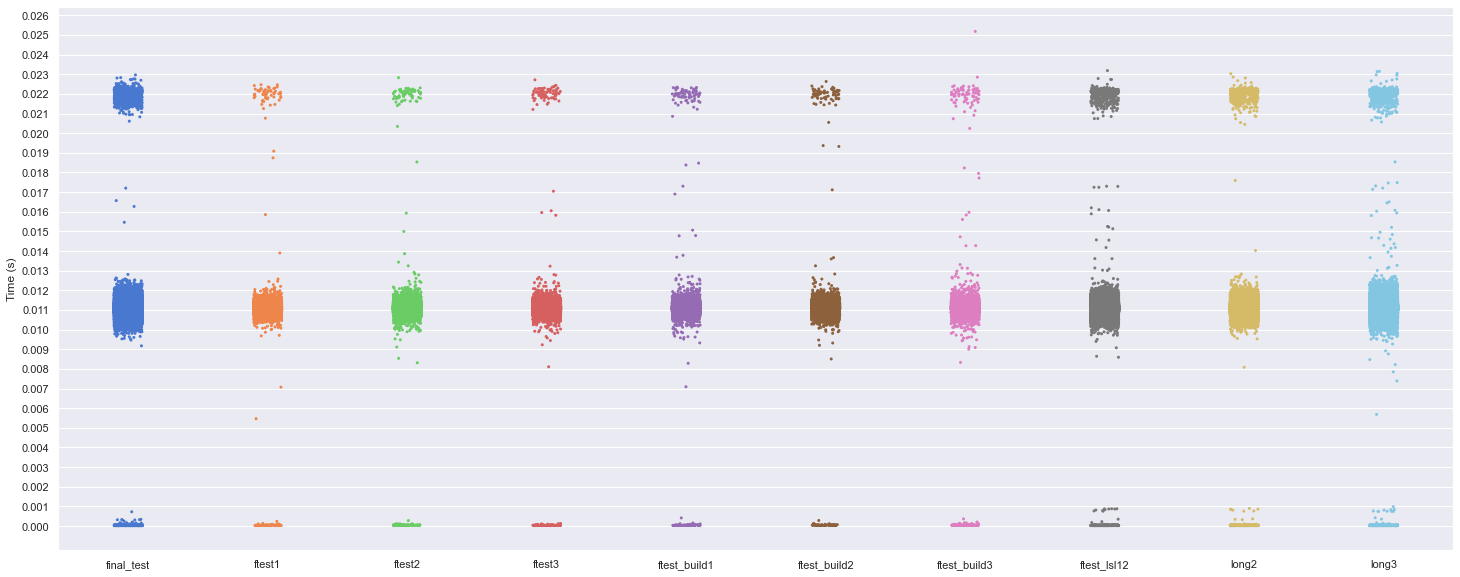

In [124]:
def strip_plot(data, xticks, alpha=1):
    g = sns.stripplot(data=data, palette="muted", size=3, alpha=alpha)
    g.set_xticklabels(xticks)
    g.set_yticks(np.arange(0, g.get_ylim()[1], 0.001))
    plt.ylabel("Time (s)")
    plt.show()


sns.set(rc={"figure.figsize": (25, 10)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style
strip_plot(u_dist, files)

Strip plots (better density visualization)

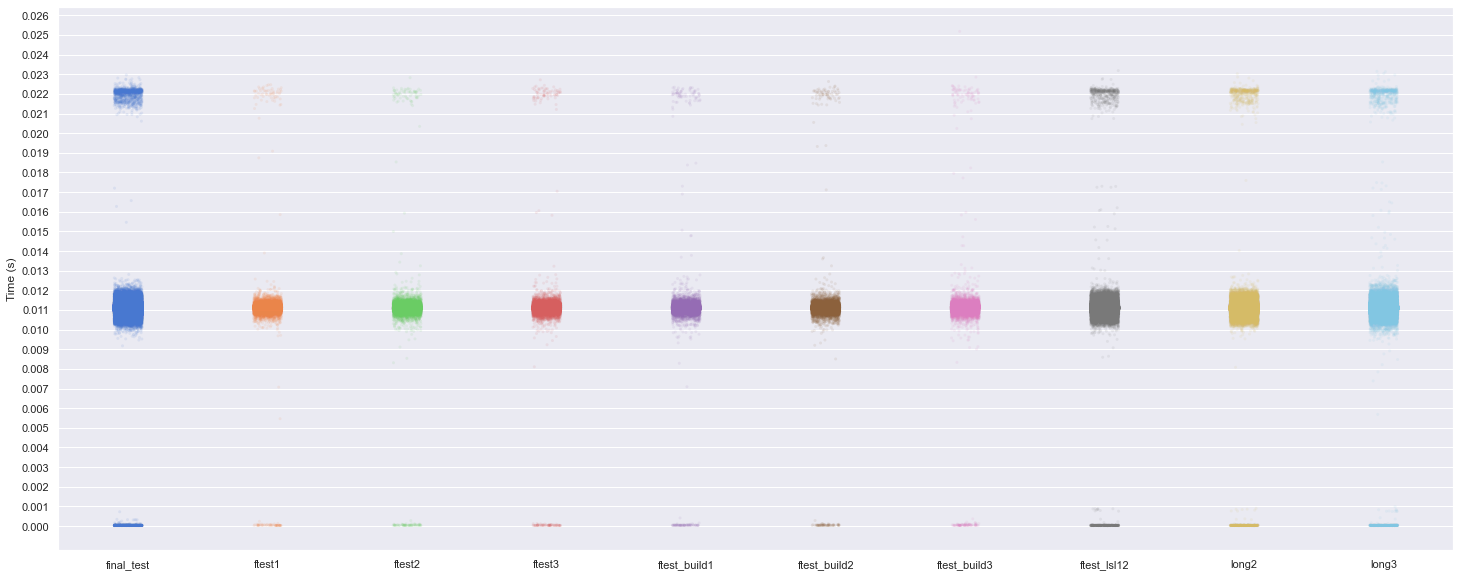

In [129]:
sns.set_style("darkgrid")  # set seaborn plotting style
strip_plot(u_dist, files, 0.1)  # change alpha for a stronger density contrast

Distplots

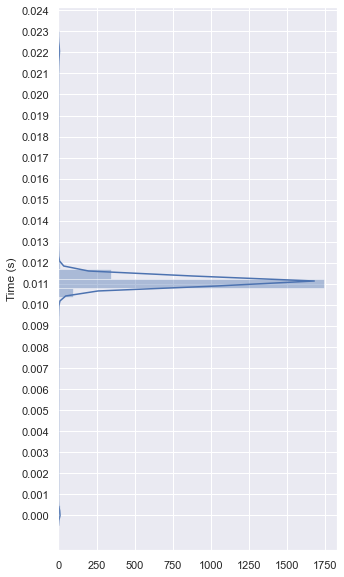

In [170]:
sns.set(rc={"figure.figsize": (5, 10)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style
# g = sns.stripplot(data=u_dist[1], palette="muted", size=3, alpha=1)
g = sns.distplot(u_dist[1], vertical=True)
# g.set_xticklabels(files)
g.set_yticks(np.arange(0, g.get_ylim()[1], 0.001))
plt.ylabel("Time (s)")
plt.show()

Boxen plots

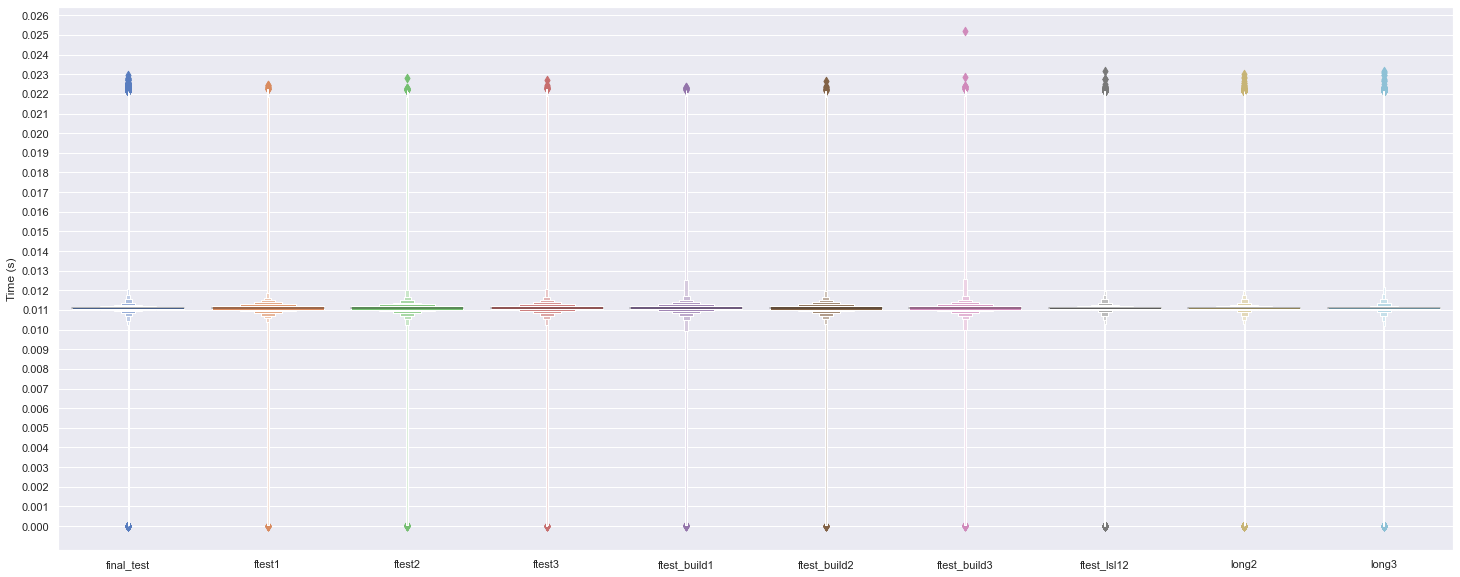

In [166]:
sns.set(rc={"figure.figsize": (25, 10)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style
g = sns.boxenplot(data=u_dist, palette="muted")
g.set_xticklabels(files)
g.set_yticks(np.arange(0, g.get_ylim()[1], 0.001))
plt.ylabel("Time (s)")
plt.show()

Violin plots

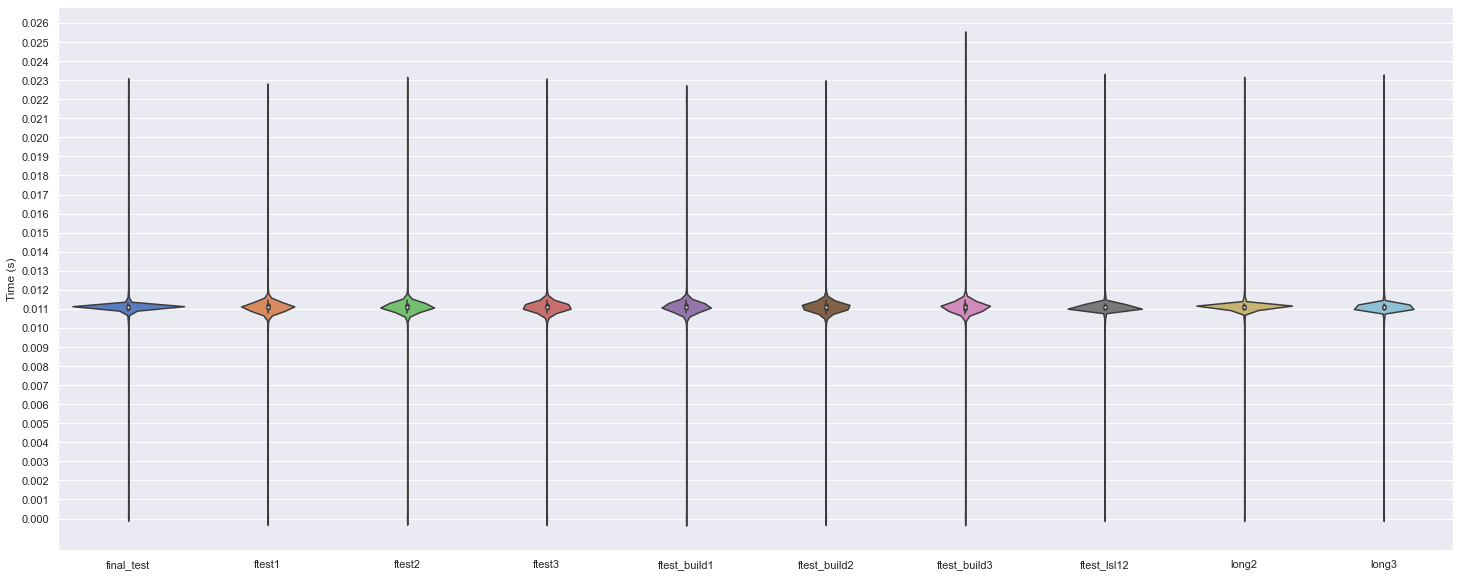

In [169]:
sns.set(rc={"figure.figsize": (25, 10)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style
g = sns.violinplot(data=u_dist, palette="muted")
g.set_xticklabels(files)
g.set_yticks(np.arange(0, g.get_ylim()[1], 0.001))
plt.ylabel("Time (s)")
plt.show()

Average violinplot with quartile

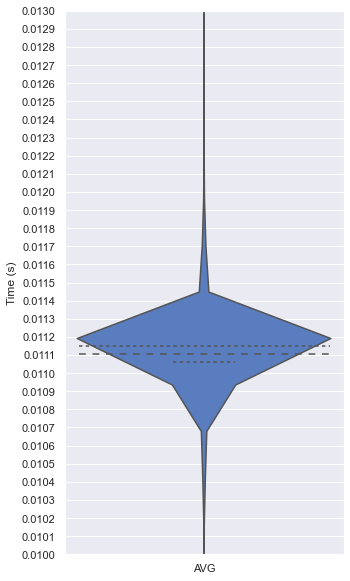

In [162]:
u_avg = np.concatenate(u_dist).ravel()  # flatten the 2D array into 1D

sns.set_style("whitegrid")  # set seaborn plotting style
sns.set(rc={"figure.figsize": (5, 10)})  # set figure size
g = sns.violinplot(data=u_avg, palette="muted", orient="v", inner="quartile")
g.set_xticklabels(["AVG"])
g.set_yticks(np.arange(0, g.get_ylim()[1], 0.0001))
plt.ylim(0.010, 0.013)
plt.ylabel("Time (s)")
plt.show()

#### __Data preview__

How does the data look like? Plot of the 4 streams (Unity color, Unity audio, EEG diode, EEG microphone)

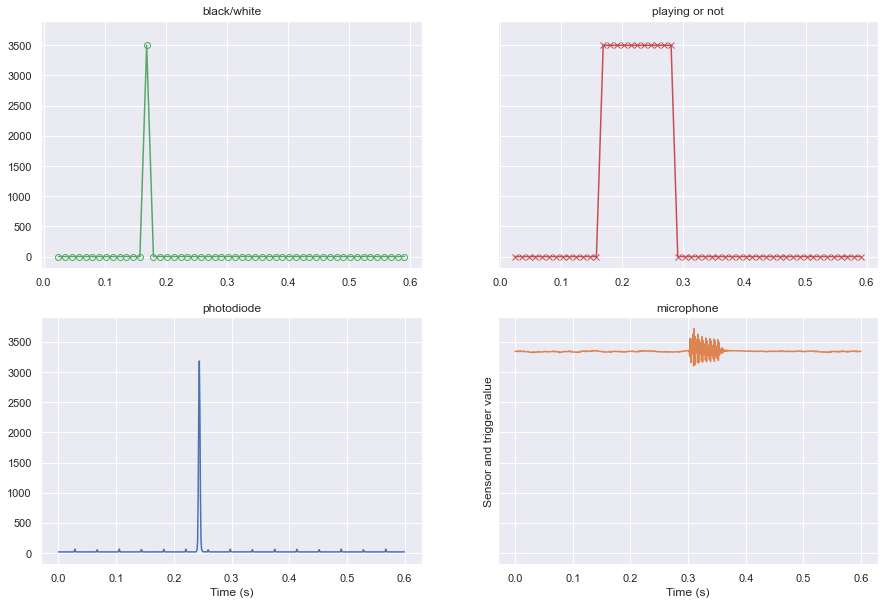

In [20]:
sns.set(rc={"figure.figsize": (14, 5)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style

f_n = -0.1  # starting point (s)
s_n = 0.6  # ending point (s)

start_e = 1024 * f_n  # eeg sampling rate = 1024
start_u = 90 * f_n  # unity sampling rate = 90

e_samples = 1024 * s_n  # N of eeg in 5 s
u_samples = 90 * s_n  # N of unity in 5 s
u_height = 3500  # factor to improve unity (true/1) values visualization

file = recordings[0]["file"].split(".")[0]
e = copy.deepcopy(recordings[0]["eeg"])
u = copy.deepcopy(recordings[0]["unity"])
e_t = e["timestamps"]
u_t = u["timestamps"]
e_a = e["audio"]
e_c = e["color"]
u_c = u["color"]
u_a = u["audio"]
# fix diff array sizes for unity color and audio arrays
u_diff = len(u_c) - len(u_t)
if u_diff > 0:
    # remove the diff from the end of the array
    u_c = u_c[:-u_diff]
elif u_diff < 0:
    # add the diff from the end of the array
    for i in range(abs(u_diff)):
        u_c = np.append(u_c, u_c[-1])

# select range of timestamps, diode and microphone values (eeg)
e_time_selection = e_t[(e_t > f_n) & (e_t < s_n)]
e_color_selection = e_c[(e_t > f_n) & (e_t < s_n)]
e_audio_selection = e_a[(e_t > f_n) & (e_t < s_n)]

# select range of timestamps, color and audio values (unity)
u_time_selection = u_t[(u_t > f_n) & (u_t < s_n)]
u_color_selection = u_c[(u_t > f_n) & (u_t < s_n)]
u_audio_selection = u_a[(u_t > f_n) & (u_t < s_n)]
preview = [
    ["black/white", u_time_selection, u_color_selection * u_height],
    ["playing or not", u_time_selection, u_audio_selection * u_height],
    ["photodiode", e_time_selection, e_color_selection * 0.05],
    ["microphone", e_time_selection, e_audio_selection * 1.5],
]

# plot the selected range to compare eeg vs unity values
nplots = 4  # number of subplots

# define colors, got from plt.gca().lines[-1].get_color() after each .plot call
c_diode = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
c_micro = (0.8666666666666667, 0.5176470588235295, 0.3215686274509804)
c_color = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)
c_audio = (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)

# define subplots
fig, axes = plt.subplots(nrows=2, ncols=int(nplots / 2), figsize=(15, 10), sharey=True)
axes[0, 0].plot(
    preview[0][1], preview[0][2], marker="o", color=c_color, markerfacecolor="None"
)
axes[0, 0].set_title(preview[0][0])
axes[0, 1].plot(preview[1][1], preview[1][2], marker="x", color=c_audio)
axes[0, 1].set_title(preview[1][0])
axes[1, 0].plot(preview[2][1], preview[2][2], color=c_diode)
axes[1, 0].set_title(preview[2][0])
axes[1, 1].plot(preview[3][1], preview[3][2], color=c_micro)
axes[1, 1].set_title(preview[3][0])

for ax in axes[1, :]:
    ax.set_xlabel("Time (s)")  # set x-axis label
plt.show()

Short preview of all recordings

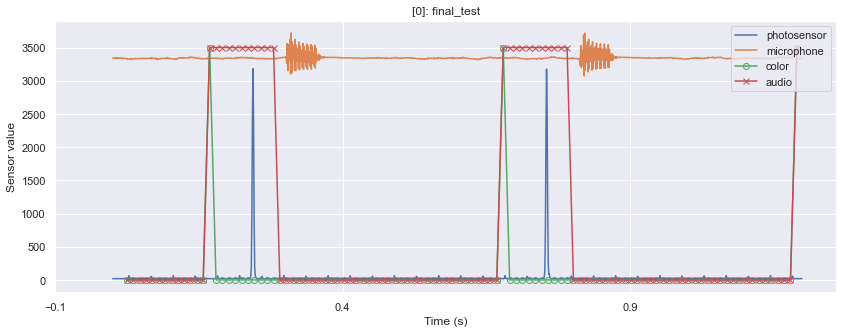

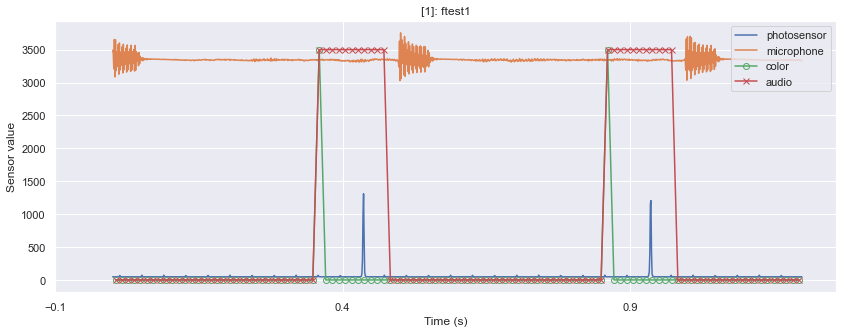

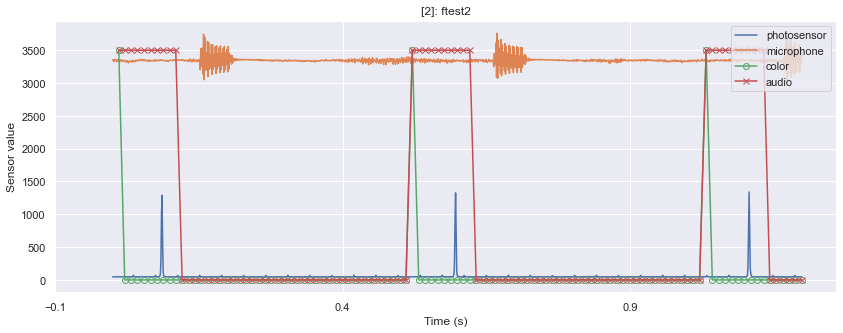

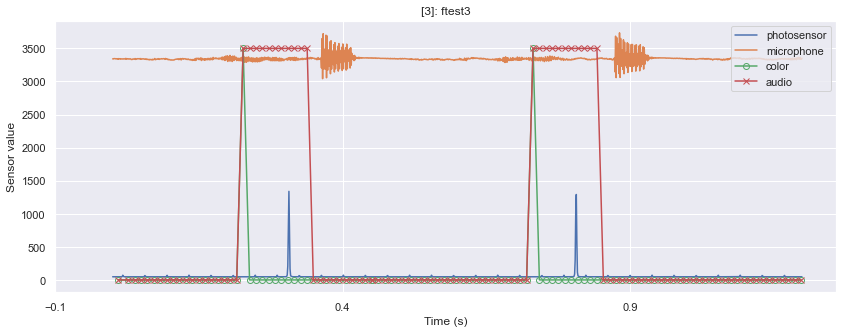

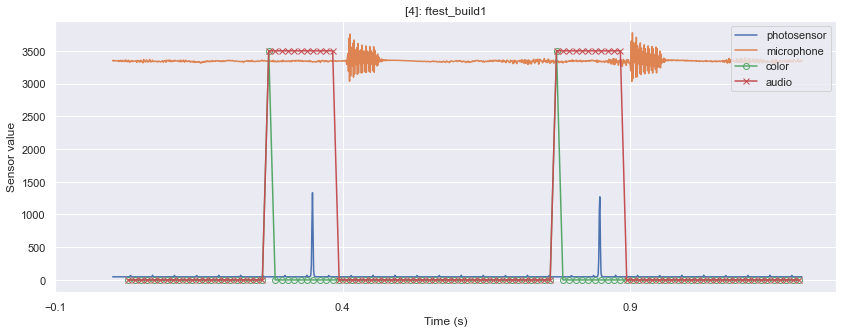

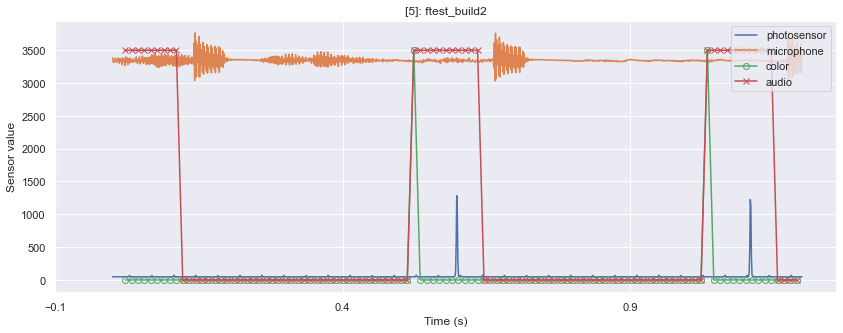

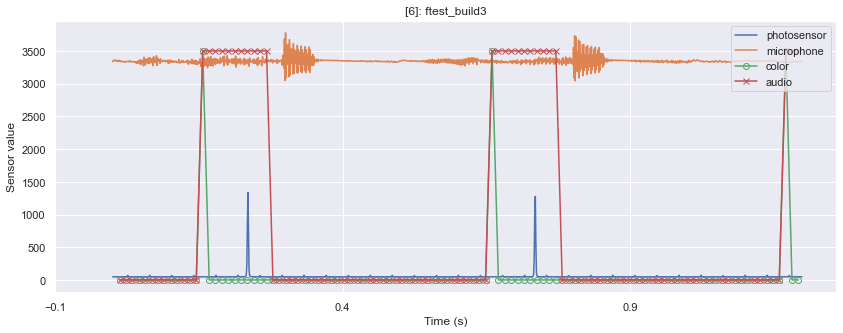

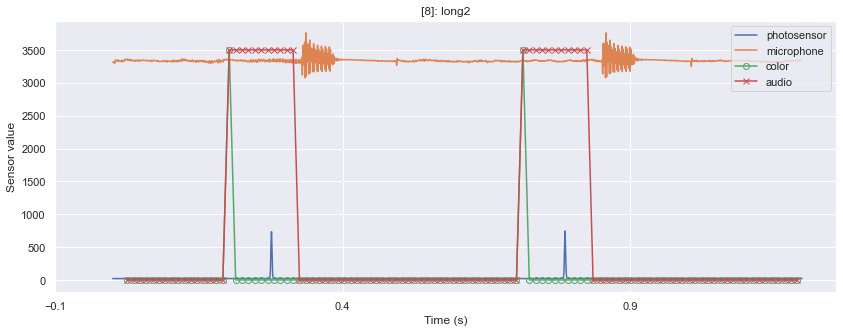

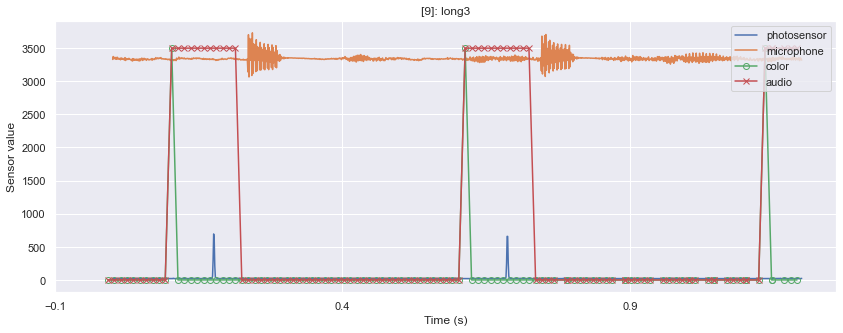

10: long4 -> u_c is 1 sample/s larger than u_t


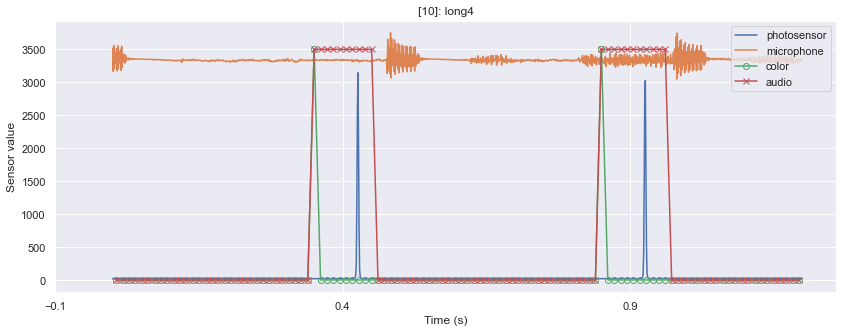

In [16]:
# interactive: widget, not interactive: inline
sns.set(rc={"figure.figsize": (14, 5)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style

f_n = -0.1  # starting point (s)
s_n = 1.2  # ending point (s)

start_e = 1024 * f_n  # eeg sampling rate = 1024
start_u = 90 * f_n  # unity sampling rate = 90

e_samples = 1024 * s_n  # N of eeg in 5 s
u_samples = 90 * s_n  # N of unity in 5 s
u_height = 3500  # factor to improve unity (true/1) values visualization

for k in recordings:
    if recordings[k]["lsl_aligned"]:
        file = recordings[k]["file"].split(".")[0]
        e = copy.deepcopy(recordings[k]["eeg"])
        u = copy.deepcopy(recordings[k]["unity"])
        e_t = e["timestamps"]
        u_t = u["timestamps"]
        e_a = e["audio"]
        e_c = e["color"]
        u_c = u["color"]
        u_a = u["audio"]
        # fix diff array sizes for unity color and audio arrays
        u_diff = len(u_c) - len(u_t)
        if u_diff > 0:
            print(f"{k}: {file} -> u_c is {u_diff} sample/s larger than u_t")
            # remove the diff from the end of the array
            u_c = u_c[:-u_diff]
        elif u_diff < 0:
            print(f"{k}: {file} -> u_c is {abs(u_diff)} sample/s smaller than u_t")
            # add the diff from the end of the array
            for i in range(abs(u_diff)):
                u_c = np.append(u_c, u_c[-1])

        # select range of timestamps, diode and microphone values (eeg)
        e_time_selection = e_t[(e_t > f_n) & (e_t < s_n)]
        e_color_selection = e_c[(e_t > f_n) & (e_t < s_n)]
        e_audio_selection = e_a[(e_t > f_n) & (e_t < s_n)]

        # select range of timestamps, color and audio values (unity)
        u_time_selection = u_t[(u_t > f_n) & (u_t < s_n)]
        u_color_selection = u_c[(u_t > f_n) & (u_t < s_n)]
        u_audio_selection = u_a[(u_t > f_n) & (u_t < s_n)]

        # plot the selected range to compare eeg vs unity values
        plt.plot(e_time_selection, e_color_selection * 0.05)
        plt.plot(e_time_selection, e_audio_selection * 1.5)
        plt.plot(
            u_time_selection,
            u_color_selection * u_height,
            marker="o",
            markerfacecolor="None",
        )
        plt.plot(u_time_selection, u_audio_selection * u_height, marker="x")

        plt.title(f"[{k}]: {file}")
        plt.ylabel("Sensor and trigger value")
        plt.xlabel("Time (s)")
        plt.xticks(np.arange(f_n, s_n, step=0.5))
        labels = ["photosensor", "microphone", "color", "audio"]
        plt.legend(labels, loc="upper right")  # set the legend
        plt.show()

#### __Calculating the Latencies__

In [17]:
c_diff_stats = pd.DataFrame()
a_diff_stats = pd.DataFrame()
for k in recordings:
    if recordings[k]["lsl_aligned"]:
        file = recordings[k]["file"].split(".")[0]
        e_color = recordings[k]["eeg"]["color"]
        e_audio = recordings[k]["eeg"]["audio"]
        e_time = recordings[k]["eeg"]["timestamps"]
        u_audio = recordings[k]["unity"]["audio"]
        u_color = recordings[k]["unity"]["color"]
        u_time = recordings[k]["unity"]["timestamps"]

        # get all the first peaks of each of the four recordings
        e_col_peaks = find_peaks(e_color, height=10000, distance=400)
        e_audio_peaks = find_peaks(e_audio, height=2100, distance=400)
        u_col_peaks = find_peaks(u_color)
        u_audio_peaks = find_peaks(u_audio)

        # since we are only intersted in the position of the peaks not the height, lets only take the first column
        ec_peak = e_col_peaks[0]
        ea_peak = e_audio_peaks[0]
        uc_peak = u_col_peaks[0]
        ua_peak = u_audio_peaks[0]

        # now we have the column where the peak occurs, now we need the corresponding time stamp
        ec_time = [e_time[e] for e in ec_peak]
        ea_time = [e_time[e] for e in ea_peak]
        uc_time = [u_time[e] for e in uc_peak]
        ua_time = [u_time[e] for e in ua_peak]

        # DIODE
        c_diff = []
        length = len(uc_time)
        # to make sure we do not start with j = 0 if EEG starts before Unity
        j = 1 if np.array(uc_time)[0] > 0.25 else 0
        for i in range(length):
            if (uc_time[i] - ec_time[j] > -0.25) and (uc_time[i] - ec_time[j] < 0):
                # add the difference between EEG and unity peak
                c_diff.append(uc_time[i] - ec_time[j])
                if j < len(ec_time) - 1:
                    j = j + 1
            else:
                # add nan if there is no EEG peak
                c_diff.append(np.nan)

        # MICROPHONE
        a_diff = []
        length = len(ua_time)
        j = 1 if np.array(ua_time)[0] > 0.25 else 0
        for i in range(length):
            if (ua_time[i] - ea_time[j] > -0.3) and (ua_time[i] - ea_time[j] < 0):
                # print(uc_time[i] - ec_time[j])
                a_diff.append(ua_time[i] - ea_time[j])
                if j < len(ea_time):
                    j = j + 1
            else:
                a_diff.append(np.nan)

        c_current = pd.DataFrame(c_diff, columns=[file])
        if c_diff_stats.empty:  # first file
            c_diff_stats = pd.DataFrame(c_current.describe())
        else:
            c_diff_stats = pd.merge(
                c_diff_stats, c_current.describe(), left_index=True, right_index=True
            )

        a_current = pd.DataFrame(a_diff, columns=[file])
        if a_diff_stats.empty:  # first file
            a_diff_stats = pd.DataFrame(a_current.describe())
        else:
            a_diff_stats = pd.merge(
                a_diff_stats, a_current.describe(), left_index=True, right_index=True
            )

        # check the nan values (and compare them to the graph)
        c_nan_val = []
        a_nan_val = []
        # get the indices of all nan values so we can check the missing audio and color peaks
        c_nan_val.append(np.argwhere(np.isnan(c_diff)))
        a_nan_val.append(np.argwhere(np.isnan(a_diff)))
        c_n = np.ravel(c_nan_val)  # to make it look nicer
        a_n = np.ravel(a_nan_val)  # to make it look nicer
        # contains the untiy timestamps when the diode is missing --> to check in graph
        missing_diode = np.array(uc_time)[np.array(c_n)]
        missing_mic = np.array(ua_time)[np.array(a_n)]
        print(f"{k}: {file}[diode] =\n{missing_diode}")
        print(f"{k}: {file}[mic] =\n{missing_diode}")

# include grand averages
a_avg = pd.DataFrame(a_diff_stats.mean(axis=1), columns=["AVG"])
a_diff_stats = pd.merge(a_diff_stats, a_avg, left_index=True, right_index=True)
c_avg = pd.DataFrame(c_diff_stats.mean(axis=1), columns=["AVG"])
c_diff_stats = pd.merge(c_diff_stats, c_avg, left_index=True, right_index=True)

0: final_test[diode] =
[  47.10411348  236.03184913  330.95657318  424.31469914  457.96736104
  518.62859533  613.57583883  645.21764615  834.08953128  927.98111373
  959.62282635 1054.99210119 1116.73102738 1148.36156207 1369.30893329
 1432.56985397 1525.92812783 1651.95027119 1903.48341626 1935.61392327
 1997.87507823 2157.16090352 2218.20006085 2312.88041846 2501.67478191
 2502.68610777 2628.34158471 2659.8834378  2690.42478627 2754.53011033
 2847.65528657 3005.33005977 3225.22166973 3256.78567878 3258.30780717
 3288.28274687 3539.83821109 3571.43538181 3634.55204228 3666.12732185
 3791.72745667 3856.85449111]
0: final_test[mic] =
[  47.10411348  236.03184913  330.95657318  424.31469914  457.96736104
  518.62859533  613.57583883  645.21764615  834.08953128  927.98111373
  959.62282635 1054.99210119 1116.73102738 1148.36156207 1369.30893329
 1432.56985397 1525.92812783 1651.95027119 1903.48341626 1935.61392327
 1997.87507823 2157.16090352 2218.20006085 2312.88041846 2501.67478191
 25

#### __Descriptive Statistics__ 

###### __Diode__

In [18]:
display(c_diff_stats.style.applymap(color_checks, subset=["AVG"]))

,final_test,ftest1,ftest2,ftest3,ftest_build1,ftest_build2,ftest_build3,long2,long3,long4,AVG
count,7706.000000,236.000000,268.000000,264.000000,241.000000,257.000000,282.000000,3520.000000,3604.000000,473.000000,1685.100000
mean,-0.075361,-0.075034,-0.075027,-0.075026,-0.075049,-0.075051,-0.075070,-0.073522,-0.073504,-0.076055,-0.074870
std,0.000301,0.000477,0.000383,0.000507,0.000342,0.000543,0.000660,0.000365,0.000406,0.000422,0.000441
min,-0.075989,-0.080321,-0.077808,-0.079667,-0.076752,-0.080420,-0.080432,-0.075394,-0.077715,-0.081206,-0.078570
25%,-0.075610,-0.075292,-0.075274,-0.075263,-0.075269,-0.075289,-0.075275,-0.073777,-0.073758,-0.076294,-0.075110
50%,-0.075364,-0.075015,-0.075050,-0.075005,-0.075040,-0.075041,-0.074964,-0.073521,-0.073511,-0.076036,-0.074855
75%,-0.075118,-0.074741,-0.074783,-0.074752,-0.074796,-0.074769,-0.074765,-0.073278,-0.073266,-0.075794,-0.074606
max,-0.074084,-0.073792,-0.072521,-0.073762,-0.074127,-0.073756,-0.073900,-0.062520,-0.062223,-0.074548,-0.071523


###### __Speaker__

In [19]:
display(a_diff_stats.style.applymap(color_checks, subset=["AVG"]))

,final_test,ftest1,ftest2,ftest3,ftest_build1,ftest_build2,ftest_build3,long2,long3,long4,AVG
count,7667.000000,239.000000,271.000000,266.000000,244.000000,262.000000,284.000000,3531.000000,43.000000,4195.000000,1700.200000
mean,-0.089211,-0.093448,-0.092461,-0.090780,-0.087598,-0.086650,-0.091163,-0.086559,-0.094359,-0.086831,-0.089906
std,0.006339,0.005466,0.005722,0.007148,0.005177,0.005269,0.005277,0.005392,0.036455,0.005384,0.008763
min,-0.124171,-0.107841,-0.107332,-0.109988,-0.101148,-0.100492,-0.105271,-0.105626,-0.283456,-0.109744,-0.125507
25%,-0.093308,-0.097192,-0.096314,-0.094695,-0.091121,-0.090502,-0.094684,-0.090131,-0.092951,-0.090317,-0.093122
50%,-0.089200,-0.092714,-0.092877,-0.091446,-0.087118,-0.086548,-0.091167,-0.086238,-0.088779,-0.086436,-0.089252
75%,-0.085054,-0.089552,-0.088943,-0.086339,-0.083412,-0.083038,-0.086957,-0.082709,-0.085059,-0.082945,-0.085401
max,-0.047016,-0.082094,-0.071488,-0.064127,-0.075282,-0.075532,-0.079370,-0.071732,-0.014531,-0.071797,-0.065297
